In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from rve_utils import CMAPSS
from collections import defaultdict
from torch import optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_dim, num_layers=1, bidirectional=True):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if self.bidirectional else 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc_mean = nn.Linear(in_features=self.num_directions*hidden_size, out_features=latent_dim)
        self.fc_log_var = nn.Linear(in_features=self.num_directions*hidden_size, out_features=latent_dim)
    
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(var.device)               
        z = mean + var*epsilon                          
        return z
    
    def forward(self, x):
        batch_size = x.shape[0]
        _, (h_n, _) = self.lstm(x)
        # h_n of shape (num_layers * num_directions, batch, hidden_size)
        h_n = h_n.view(self.num_layers, self.num_directions, batch_size, self.hidden_size)
        h = torch.cat((h_n[-1,-2,:,:], h_n[-1,-1,:,:]), dim = 1)
        mean = self.fc_mean(h)
        log_var = self.fc_log_var(h)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        return z, mean, log_var   
        

In [3]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_dim, window_size, num_layers=1, biderectional=True):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        self.biderectional = biderectional
        self.num_directions = 2 if self.biderectional else 1
        
        self.lstm_to_hidden = nn.LSTM(input_size=latent_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.lstm_to_output = nn.LSTM(input_size=self.num_directions*hidden_size, hidden_size=input_size, batch_first=True)

    def forward(self, z):
        latent_z = z.unsqueeze(1).repeat(1, window_size, 1)
        out, _ = self.lstm_to_hidden(latent_z)
        out, _ = self.lstm_to_output(out)
        return out

In [4]:
class RVE(nn.Module):
    
    def __init__(self, encoder, decoder=None, reconstruct=False):
        super(RVE, self).__init__()
        self.decode_mode = reconstruct
        if self.decode_mode:
            assert isinstance(decoder, nn.Module), "You should to pass a valid decoder"
            self.decoder = decoder
        self.encoder = encoder
        self.regressor = nn.Sequential(
            nn.Linear(self.encoder.latent_dim, 200), 
            nn.Tanh(), 
            nn.Linear(200, 1)
        )
    def forward(self, x):
        batch_size, time_steps = x.shape[0], x.shape[1]
        z, mean, log_var = self.encoder(x)
        y_hat = self.regressor(z)
        if self.decode_mode:
            x_hat = self.decoder(z)
            return y_hat, z, mean, log_var, x_hat

        return y_hat, z, mean, log_var
    
    def get_loss(self, mean, log_var, y, y_hat, x, x_hat=None):
        kl_loss = RVE.kl_loss(mean, log_var)
        reg_loss = RVE.reg_loss(y, y_hat)
        if self.decode_mode:
            assert x_hat is not None, "You should pass x_hat"
            reconstruction_loss = RVE.reconstruction_loss(x, x_hat)
            return kl_loss + reg_loss + reconstruction_loss
        return kl_loss + reg_loss
            
                        

In [5]:
def get_RVE_model(input_size, hidden_size, latent_dim, window_size, num_layers=1, biderectional=True, reconstruct=False):
    enc_block = Encoder(
        input_size=input_size, 
        hidden_size=hidden_size, 
        latent_dim=latent_dim, 
        num_layers=num_layers
    )
    dec_block = Decoder(
        input_size=input_size, 
        hidden_size=hidden_size, 
        latent_dim=latent_dim, 
        window_size=window_size, 
        num_layers=num_layers
    )
    model = RVE(enc_block, dec_block, reconstruct=reconstruct)
    return model
    

In [6]:
class Trainer:
    
    @staticmethod
    def score(y_hat, y):
        if torch.is_tensor(y_hat):
            y_hat = y_hat.detach().cpu().numpy()
        if torch.is_tensor(y):
            y = y.detach().cpu().numpy()

        error = y_hat - y
        pos_e = np.exp(-error[error < 0] / 13) - 1
        neg_e = np.exp(error[error >= 0] / 10) - 1
        return sum(pos_e) + sum(neg_e)
    
    @staticmethod
    def kl_loss(mean, log_var):
        loss = -0.5 * (1 + log_var - mean**2 - torch.exp(log_var))
        loss = torch.mean(torch.sum(loss, axis=1))
        return loss
    
    @staticmethod
    def reg_loss(y, y_hat):
        loss = F.mse_loss(y, y_hat)
        loss = torch.mean(loss)
        return loss
    
    @staticmethod
    def reconstruction_loss(x, x_hat):
        loss = F.mse_loss(x, x_hat)
        loss = torch.mean(loss)
        return loss
    
    def __init__(self, model, train_loader, optimizer, val_loader=None, verbose=False):
        self.train_loader = train_loader
        if val_loader is not None:
            self.val_loader = val_loader
            self.validate = True
        else:
            self.validate = False
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.history = defaultdict(list)
        self.epochs=0
        self.verbose = verbose
        
    def train(self, n_epoch):
        for i in range(n_epoch):
            self.train_epoch()
            self.epochs+=1
            if self.verbose:
                print(f"Epoch:{self.epochs} "
                      f"Train: Loss: {round(self.history['train_loss'][-1], 2)} "
                      f"kl Loss: {round(self.history['train_kl_loss'][-1], 2)} "
                      f"reg Loss: {round(self.history['train_reg_loss'][-1], 2)} "
                      f"Valid: kl Loss: {round(self.history['valid_kl_loss'][-1], 2)} "
                      f"reg Loss: {round(self.history['valid_reg_loss'][-1], 2)} "
                      f"Valid Loss: {round(self.history['valid_loss'][-1], 2)} "
                      f"Valid Score: {round(self.history['valid_score'][-1], 2)}"
                      )
            
    def train_epoch(self):
        epoch_loss = 0
        kl_loss_ep = 0
        reg_loss_ep = 0
        recon_loss_ep = 0
        self.model.train()
        for batch_idx, data in enumerate(self.train_loader):
            self.optimizer.zero_grad()
            x, y = data
            x, y = x.to(self.device), y.to(self.device)
            if self.model.decode_mode:
                y_hat, z, mean, log_var, x_hat = self.model(x)
                kl_loss = Trainer.kl_loss(mean, log_var)
                reg_loss = Trainer.reg_loss(y, y_hat)
                recon_loss = Trainer.reconstruction_loss(x, x_hat)
                loss = kl_loss + reg_loss + recon_loss

            else:
                y_hat, z, mean, log_var = self.model(x)
                kl_loss = Trainer.kl_loss(mean, log_var)
                reg_loss = Trainer.reg_loss(y, y_hat)
                loss = kl_loss + reg_loss 

            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
            kl_loss_ep += kl_loss.item()
            reg_loss_ep += reg_loss.item()

        epoch_loss = (epoch_loss)
        self.history['train_loss'].append(epoch_loss)
        self.history['train_kl_loss'].append(kl_loss_ep)
        self.history['train_reg_loss'].append(reg_loss_ep)
        if self.validate:
            self.test_valid_epoch()
        

    def test_valid_epoch(self):
        data_loader = self.val_loader
        epoch_loss = 0
        epoch_score = 0
        kl_loss_ep = 0
        reg_loss_ep = 0
        recon_loss_ep = 0
        self.model.eval()
        for batch_idx, data in enumerate(data_loader):
            with torch.no_grad():
                x, y = data
                x, y = x.to(self.device), y.to(self.device)
                if self.model.decode_mode:
                    y_hat, z, mean, log_var, x_hat = self.model(x)
                    kl_loss = Trainer.kl_loss(mean, log_var)
                    reg_loss = Trainer.reg_loss(y, y_hat)
                    recon_loss = Trainer.reconstruction_loss(x, x_hat)
                    loss = kl_loss + reg_loss + recon_loss
                else:
                    y_hat, z, mean, log_var = self.model(x)
                    kl_loss = Trainer.kl_loss(mean, log_var)
                    reg_loss = Trainer.reg_loss(y, y_hat)
                    loss = kl_loss + reg_loss 

                epoch_loss += loss.item()
                kl_loss_ep += kl_loss.item()
                reg_loss_ep += reg_loss.item()
                epoch_score += Trainer.score(y_hat, y)

        epoch_loss = epoch_loss 
        self.history['valid_loss'].append(epoch_loss)
        self.history['valid_score'].append(epoch_score)
        self.history['valid_kl_loss'].append(kl_loss_ep)
        self.history['valid_reg_loss'].append(reg_loss_ep)

In [7]:
def viz_latent_space(model, data, targets=[], title='Final', save=False, show=True):
    data = torch.tensor(data).float()
    with torch.no_grad():
    
        z, _, _  = model.encoder(data)
    plt.figure(figsize=(8, 4))
    if len(targets)>0:
        plt.scatter(z[:, 0], z[:, 1], c=targets, s=2)
    else:
        plt.scatter(z[:, 0], z[:, 1])
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.title(title)
    if show:
        plt.tight_layout()
    if save:
        plt.savefig('./images/latent_space_epoch'+str(epoch)+'.png')

In [8]:
# sensors to work with: T30, T50, P30, PS30, phi
sensors = ['s_3', 's_4', 's_7', 's_11', 's_12']
# windows length
window_size = 30
# smoothing intensity
alpha = 0.1
# max RUL
max_rul = 125
input_size = len(sensors)
hidden_size = 200
latent_dim = 2
num_layers = 1
batch_size = 128
epochs = 10


train_loader, test_loader, val_loader = CMAPSS(
    dataset_name="FD003", 
    max_rul=max_rul, 
    train_batch_size=batch_size, 
    window_size=window_size
).get_dataloaders()

print(len(train_loader.dataset), len(test_loader.dataset), len(val_loader.dataset))


x_train = train_loader.dataset.sequences
y_train = train_loader.dataset.targets

x_val = val_loader.dataset.sequences
y_val = val_loader.dataset.targets

x_test = test_loader.dataset.sequences
y_test = test_loader.dataset.targets

Fit scaler on: 0.0_0.0_100.0
17913 100 3784


In [17]:
model = get_RVE_model(
    input_size=input_size, 
    hidden_size=hidden_size, 
    latent_dim=latent_dim, 
    window_size=window_size, 
    num_layers=num_layers, 
    biderectional=True, 
    reconstruct=True
)

optimizer = optim.Adam(model.parameters(), lr=0.0002)

trainer = Trainer(model, train_loader, optimizer, test_loader)

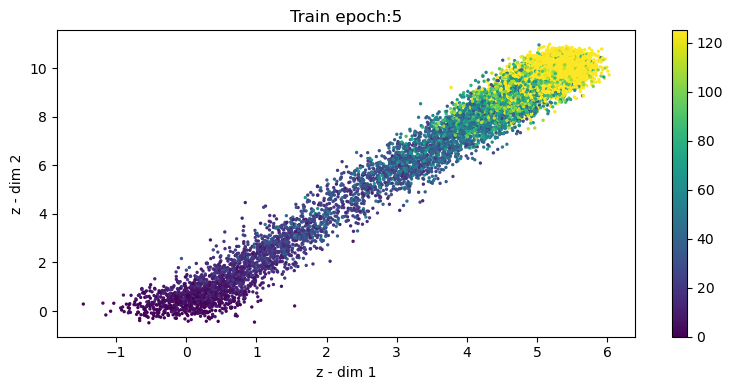

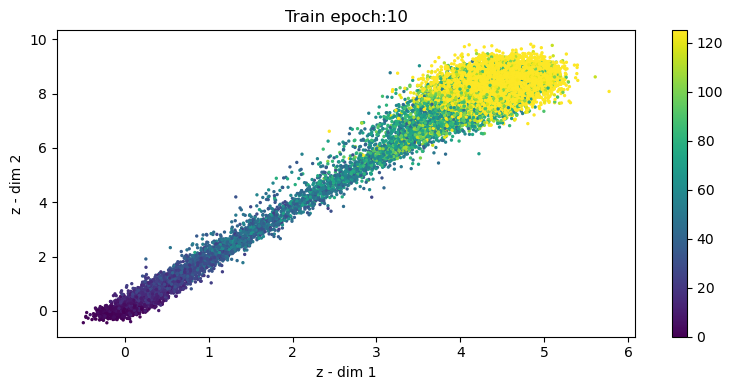

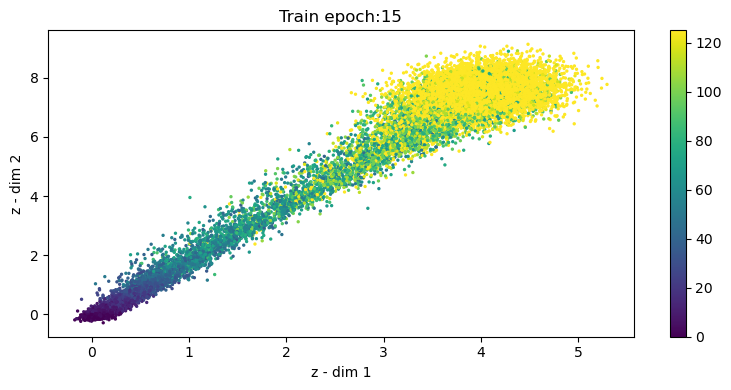

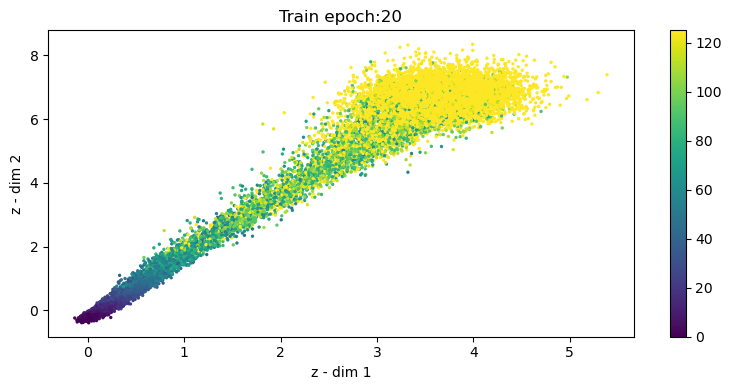

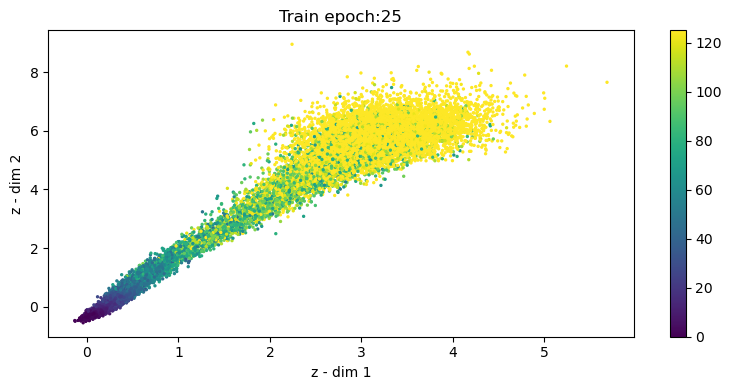

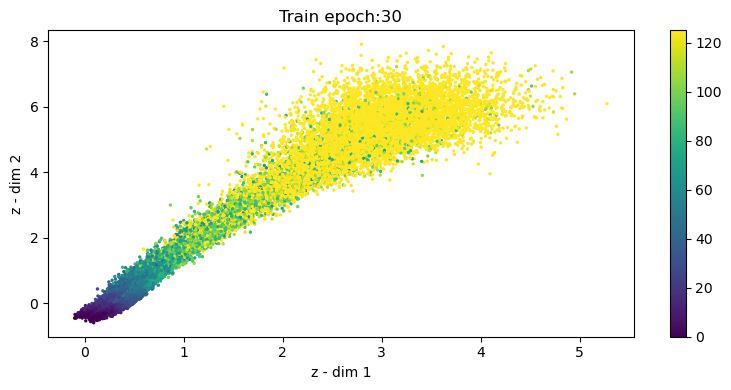

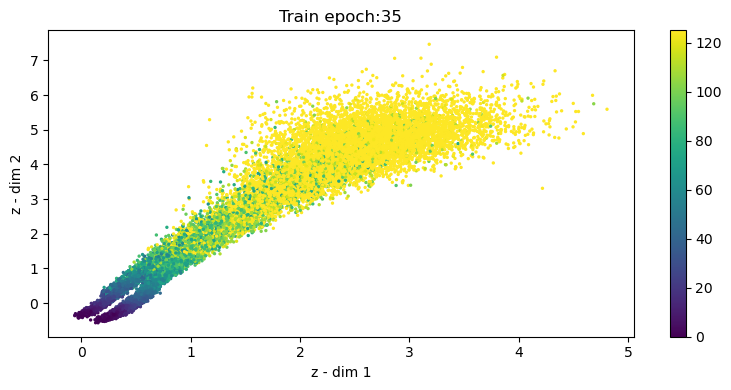

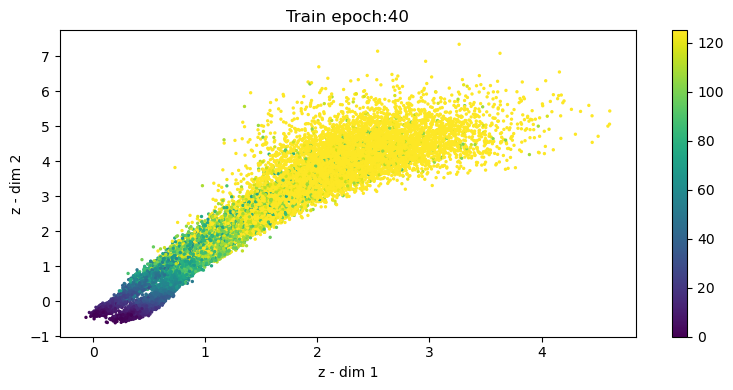

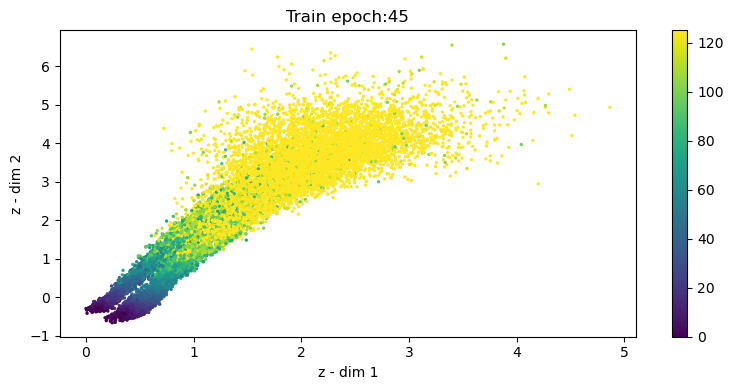

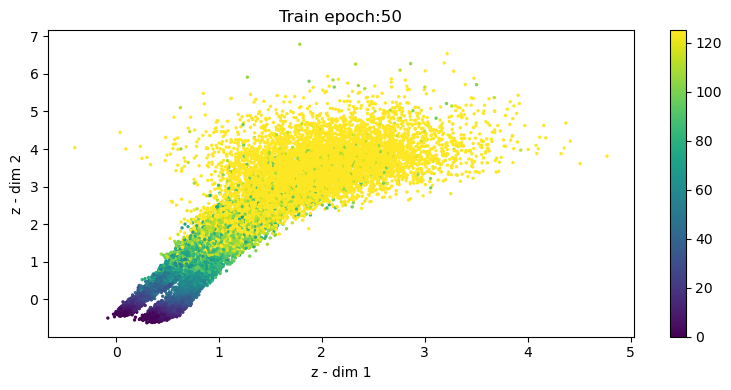

In [18]:
for _ in range(10):
    trainer.train(5)

    model.to('cpu').eval()
    epoch = trainer.epochs

    viz_latent_space(model, x_train, y_train, title=f'Train epoch:{epoch}')
    #viz_latent_space(model, x_val, y_val, title=f'Test epoch:{epoch}')
    #viz_latent_space(model, x_test, y_test, title=f'Validation epoch:{epoch}')
    model.to('cuda')